# Video Super Resolution

## By Daniel Shkreli and Victor Reyes

### Import what we need

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import lpips
import torchvision
from torchvision.datasets.video_utils import VideoClips
from torchvision import datasets, models, transforms
!pip install tqdm
from tqdm.notebook import tqdm
import os
import copy
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    
print(torch.__version__)
print(torchvision.__version__)

Using the GPU!
1.4.0
0.5.0


### Import the dataset
To do this, we will be downloading the videos of the National Geographic channel.

### Create the model
We will use resnet 18, pretrained at first.
from https://github.com/hsinyilin19/ResNetVAE


In [94]:
def initialize_resnet_model(resume_from = None):
    resnet = models.resnet18(pretrained=True)
    out_size = resnet.fc.in_features
    print("out_size:", out_size)
    layers = []
    for child in resnet.children():
        for param in child.parameters():
            param.requires_grad = False
        layers.append(child)
    resnet = nn.Sequential(*layers[:-1])
    
    #resnet.fc =  # create latent
    
    #resnet.add_module("bottleneck", nn.Sequential()
    if resume_from is not None:
        print(f"Loading weights from {resume_from}")
        model.load_state_dict(torch.load(resume_from))
    return resnet, out_size

def initialize_bottleneck(input_size, latent_size=1024):
    bottleneck = nn.Sequential(nn.Linear(input_size, latent_size),
                               nn.BatchNorm1d(latent_size, momentum=0.01))
    return bottleneck

def initialize_decoder():
    stride = (2,2)
    padding = (1,1)
    convTrans6 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=1024, out_channels=1024, kernel_size=(4,4), stride=(1,1),
                           padding=(0,0)),
        nn.BatchNorm2d(1024, momentum=0.01),
        nn.ReLU(inplace=True),
    )
    
    convTrans7 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=(4,4), stride=stride,
                           padding=padding),
        nn.BatchNorm2d(512, momentum=0.01),
        nn.ReLU(inplace=True),
    )
    
    convTrans8 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(4,4), stride=stride,
                           padding=padding),
        nn.BatchNorm2d(256, momentum=0.01),
        nn.ReLU(inplace=True),
    )
    
    convTrans9 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(4,4), stride=stride,
                           padding=padding),
        nn.BatchNorm2d(128, momentum=0.01),
        nn.ReLU(inplace=True),
    )
    
    convTrans10 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(4,4), stride=stride,
                           padding=padding),
        nn.BatchNorm2d(64, momentum=0.01),
        nn.ReLU(inplace=True),
    )
   
    convTrans11 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=(4,4), stride=stride,
                           padding=padding),
        nn.BatchNorm2d(64, momentum=0.01),
        nn.ReLU(inplace=True),
    )
    
    convTrans12 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(4,4), stride=stride,
                           padding=padding),
        nn.BatchNorm2d(32, momentum=0.01),
        nn.ReLU(inplace=True),
    )
    
    convTrans13 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=(4,4), stride=stride,
                           padding=padding),
        nn.BatchNorm2d(3, momentum=0.01),
        nn.Sigmoid(),
    )
    return nn.Sequential(convTrans6,
                         convTrans7,
                         convTrans8,
                         convTrans9,
                         convTrans10,
                         convTrans11,
                         convTrans12,
                         convTrans13) 

    
def video_loader(filename):
    clips = VideoClips([filename], clip_length_in_frames=10, frames_between_clips = 10, frame_rate=10)
    
    return clips.get_clip(clips.num_clips()//2)[0]# currently just return a clip 

input_size = 256
data_transforms = {
    'train_in': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),

        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'train_in_no_normalize': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),

        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'train_target': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(input_size*2),
        transforms.CenterCrop(input_size*2),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

def get_dataloaders(batch_size, input_size = 256, shuffle = True):
    train_dataset = datasets.DatasetFolder(root="yt-dls/train/", loader=video_loader, extensions=("mp4"))
    val_dataset = datasets.DatasetFolder(root="yt-dls/val/", loader=video_loader, extensions=("mp4"))
    test_dataset = datasets.DatasetFolder(root="yt-dls/test/", loader=video_loader, extensions=("mp4"))

    dataloaders_dict = {'train': torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True),
                       'val': torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = True),
                       'test': torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)}
    return dataloaders_dict

In [78]:
def train(model, dataloaders, num_epochs=25):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, _ in tqdm(dataloaders[phase]):
                #inputs2 = data_transforms['train'](inputs)
                # we get 10, 720, 1280, 3
                # for now, lets just get a single frame
                # perform transform on input
                transformed_input = data_transforms[phase](inputs)
                label = inputs # this makes sense, should we perform any transforms?
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    prediction = model(inputs)
                    preceptual_loss = percept(prediction, label)
                    mse_loss = nn.mse(prediction, label)
                    loss = alpha * perceptual_loss + beta * mse_loss
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                print(inputs2.shape)

def make_optimizer(bottleneck, decoder):
    # Get all the parameters
    print("bottleneck params", bottleneck.parameters())
    print("decoder params", decoder.parameters())
    params_to_update = list(bottleneck.parameters()) + list(decoder.parameters())
    print("Params to learn:")
    for name, param in bottleneck.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
    for name, param in decoder.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
    # Use SGD
    #optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
    optimizer = optim.Adagrad(params_to_update, lr=0.001)
    return optimizer

In [74]:
def fit_one_point(resnet, bottleneck, decoder, point, in_transforms, target_transforms, iterations=1000):
    batched_input_1 = []
    batched_input_2 = []
    batched_targets = []
    for example in point:  
        in_1 = in_transforms(example[0].permute(2,0,1)) # frame_i-1
        in_2 = in_transforms(example[1].permute(2,0,1)) # frame_i
        target = target_transforms(example[1].permute(2,0,1))
        batched_input_1.append(in_1)
        batched_input_2.append(in_2)
        batched_targets.append(target)
    batched_input_1 = torch.stack(batched_input_1).to(device)
    batched_input_2 = torch.stack(batched_input_2).to(device)
    batched_targets = torch.stack(batched_targets).to(device)

    optimizer = make_optimizer(bottleneck, decoder)
    resnet.eval()
    bottleneck.train()
    decoder.train()
    losses = []
    for i in range(1000):
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            embedding_1 = resnet(batched_input_1)
            embedding_2 = resnet(batched_input_2)
            #print("embeddingshape", embedding_1.shape)
            cat_latent = torch.cat((embedding_1, embedding_2), dim=1)
            moved_latent = torch.squeeze(cat_latent)
            #print("cat", cat_latent.shape)
            #print("moved", moved_latent.shape)

            latent = bottleneck(moved_latent)
            #print("latentshape", latent.shape)
            
            prediction = decoder(latent.unsqueeze(-1).unsqueeze(-1))
            #print("prediction", prediction.shape)
            #print("targets", batched_targets.shape)
            mse_loss = nn.MSELoss()
            mse_loss_val = mse_loss(prediction, batched_targets)
            loss = 1 * mse_loss_val
            print(loss)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
    return [prediction, losses]

In [83]:
# get a point
sample_video_filename = "yt-dls/train/0/Secrets of the Whales _ Official Trailer _ Disney+.mp4"
sample_video_filename2 = 'yt-dls/train/0/The Race For the COVID-19 Vaccine _ National Geographic.mp4'

sample_video = VideoClips([sample_video_filename], clip_length_in_frames=2, frames_between_clips=10, frame_rate=10)
sample_video2 = VideoClips([sample_video_filename2], clip_length_in_frames=2, frames_between_clips=10, frame_rate=10)

clip = sample_video.get_clip(0)
clip2 = sample_video2.get_clip(0)

batched_point = [clip[0], clip2[0]]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision/io/video.py:107: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  "follow-up version. Please use pts_unit 'sec'.")


  0%|          | 0/1 [00:00<?, ?it/s]

In [79]:
# fit a point
resnet, out_size = initialize_resnet_model()
resnet.to(device)
bottleneck = initialize_bottleneck(2*out_size).to(device)
decoder = initialize_decoder().to(device)
print(resnet)
print(bottleneck)
print(decoder)
last_prediction, losses = fit_one_point(resnet, bottleneck, decoder, batched_point, data_transforms['train_in'], data_transforms['train_target'])


out_size: 512
Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    

tensor(0.0487, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0481, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0472, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0463, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0451, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0444, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0426, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0424, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0401, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0406, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0381, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0379, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0359, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0353, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0347, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0345, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0338, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0334, device='cuda:0', grad_fn=<MulBack

tensor(0.0187, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0186, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0186, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0186, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0185, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0185, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0185, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0184, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0184, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0184, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0184, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0184, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0184, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0184, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0184, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0183, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0183, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0182, device='cuda:0', grad_fn=<MulBack

tensor(0.0143, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0143, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0143, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0143, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0143, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0143, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0143, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0143, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0143, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0143, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0143, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0143, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0143, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0143, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0143, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0143, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0143, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0143, device='cuda:0', grad_fn=<MulBack

tensor(0.0136, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0137, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0136, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0136, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0136, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0136, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0136, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0136, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0135, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0135, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0135, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0135, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0135, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0135, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0135, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0135, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0135, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0135, device='cuda:0', grad_fn=<MulBack

tensor(0.0131, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0131, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0131, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0131, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<MulBack

tensor(0.0126, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<MulBack

tensor(0.0123, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0122, device='cuda:0', grad_fn=<MulBack

torch.Size([3, 512, 512])
torch.Size([720, 1280, 3])
The original target frame


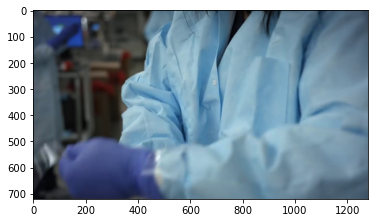

the target to optimize for


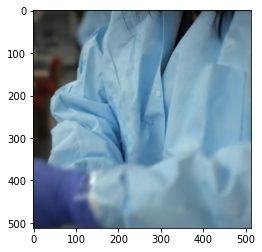

what the model saw


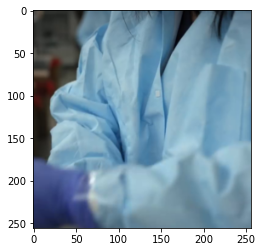

what the model made


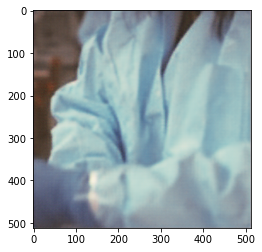

In [96]:
prediction = last_prediction[1].cpu().detach()
target = batched_point[1][1]
input_target = data_transforms['train_in_no_normalize'](batched_point[1][1].permute(2,0,1))
print(prediction.shape)
#prediction_img = transforms.ToPILImage(prediction)
print(target.shape)

print("The original target frame")
plt.imshow(target)
plt.show()

transformed_target = data_transforms['train_target'](target.permute(2,0,1))
print("the target to optimize for")
plt.imshow(transformed_target.permute(1,2,0))
plt.show()
print("what the model saw")
plt.imshow(transforms.functional.to_pil_image(input_target))
plt.show()
print("what the model made")
plt.imshow(transforms.functional.to_pil_image(prediction))
#plt.plot(losses)

In [ ]:
dataloaders_dict = get_dataloaders(1)
#print(dataloaders_dict)

point = dataloaders_dict['train']


# overfit a point
print(point)
since = time.time()

val_acc_history = []

best_model_wts = copy.deepcopy(resnet.state_dict())
best_loss = 0.0

for epoch in range(1000):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    resnet.train()
    # Each epoch has a training and validation phase
    
    running_loss = 0.0

    # Iterate over data.
    # TQDM has nice progress bars
    for inputs, _ in tqdm(dataloaders[phase]):
        #inputs2 = data_transforms['train'](inputs)
        # we get 10, 720, 1280, 3
        # for now, lets just get a single frame
        # perform transform on input
        transformed_input = data_transforms[phase](inputs)
        label = inputs # this makes sense, should we perform any transforms?
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
            prediction = model(inputs)
            preceptual_loss = percept(prediction, label)
            mse_loss = nn.mse(prediction, label)
            loss = alpha * perceptual_loss + beta * mse_loss
            if phase == 'train':
                loss.backward()
                optimizer.step()
        print(inputs2.shape)


for inputs, _ in tqdm(dataloaders_dict['val']):
    print(inputs.shape)
    inputs2 = data_transforms['train'](inputs)

    print(inputs2.shape)